# Noise Analysis

This script's purpose is to evaluate the noise across the brain and see how resilient the SNR changes with region and noise.

In [1]:
#%matplotlib widget
import scipy
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import sys
import os

In [2]:
cwd_temp = os.getcwd()
base_file = 'Regularization'
cwd_full = cwd_temp.split(base_file, 1)[0]

brain_data = scipy.io.loadmat(f'{cwd_full}{base_file}/MB_References/BLSA_1742_04_MCIAD_m41/NESMA_cropped_slice5.mat')
I_raw = brain_data['slice_oi']

subsection = False

if subsection:
    I_raw_vert = 5
    I_raw_hori = 36
    I_raw_extent = 60
    I_raw = I_raw[I_raw_vert:I_raw_vert + I_raw_extent, I_raw_hori:I_raw_hori + I_raw_extent, :]

n_vert, n_hori, n_elements = I_raw.shape

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata = np.linspace(t_increment_brain, (n_elements)*(t_increment_brain), n_elements)

#All pixels with a lower mask amplitude are considered to be free water (i.e. vesicles)
mask_amplitude = 750

#This is important for regularization if this is deemed necessary here
ob_weight = 100

MB_model = False

init_p = (0.2, 0.8, 20, 80, 1)
lb = [0,0,0,0,0]
ub = [np.inf,np.inf, 80, 300, np.inf]

# vert1 = 165
# vert2 = 180
# hori1 = 120
# hori2 = 180

# vert1 = 33
# vert2 = 43
# hori1 = 25
# hori2 = 59

vert1 = 92             #60     #108
vert2 = 110            #125     #116
hori1 = 75            #100      #86
hori2 = 130 

vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

noiseRegion = [vert1,vert2,hori1,hori2]

In [3]:
def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def get_brain_outline(raw):
    I_outline = np.zeros((n_vert,n_hori))
    for i_vert in range(n_vert):
        for i_hori in range(n_hori):
            try:
                init_sig = raw[i_vert, i_hori, 0]
                init_sig_up = raw[i_vert-1, i_hori, 0]
                init_sig_lt = raw[i_vert, i_hori-1, 0]
                init_sig_rt = raw[i_vert, i_hori+1, 0]
                init_sig_dn = raw[i_vert+1, i_hori, 0]
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = 0
    return I_outline

/home/hamptong2/anaconda3/envs/BrainReg/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/hamptong2/anaconda3/envs/BrainReg/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


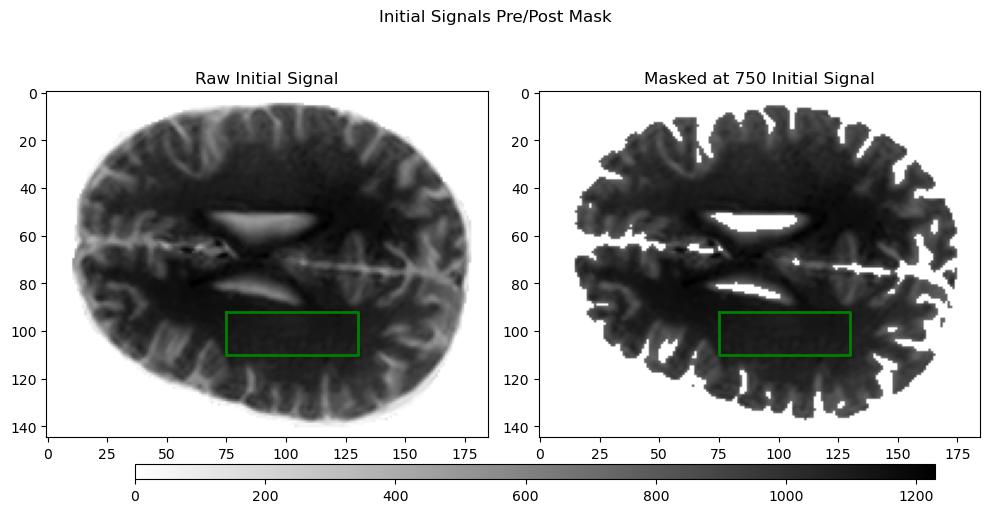

In [4]:
I_data = mask_data(I_raw, mask_amplitude)

fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(10,5))
fig.suptitle('Initial Signals Pre/Post Mask')
imc1 = ax[0].imshow(I_raw[:, :, 0], cmap = 'binary')
ax[0].set_title(f"Raw Initial Signal")
ax[0].plot(hBox,vBox, linewidth = 2, color = 'g')
imc1 = ax[1].imshow(I_data[:, :, 0], cmap = 'binary')
ax[1].set_title(f"Masked at {mask_amplitude} Initial Signal")
ax[1].plot(hBox,vBox, linewidth = 2, color = 'g')
cbar_ax = fig.add_axes([0.14, 0.04, 0.8, 0.03])

fig.colorbar(imc1, ax=ax, cax=cbar_ax, orientation = 'horizontal', fraction=0.046, pad=0.04)

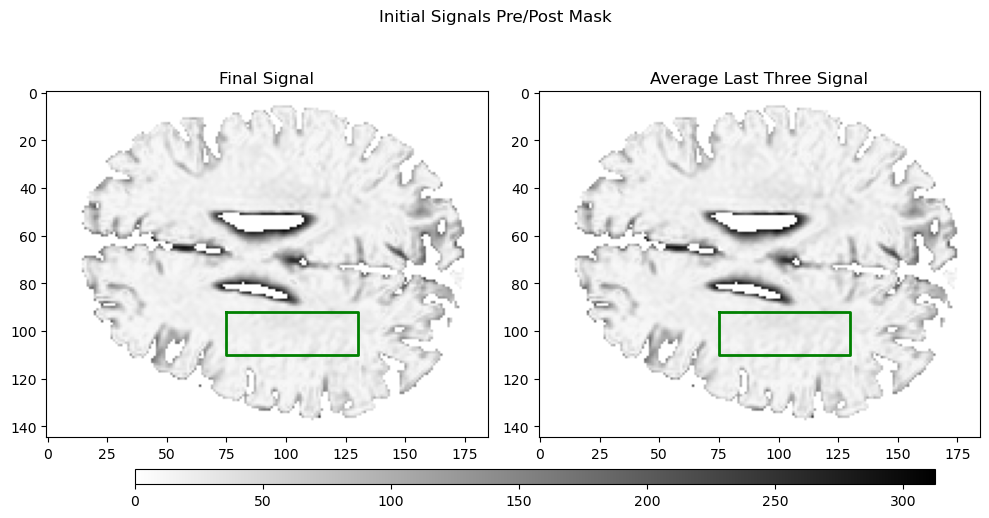

In [5]:
fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(10,5))
fig.suptitle('Initial Signals Pre/Post Mask')
imc1 = ax[0].imshow(I_data[:, :, -1], cmap = 'binary')
ax[0].set_title(f"Final Signal")
ax[0].plot(hBox,vBox, linewidth = 2, color = 'g')
imc1 = ax[1].imshow(np.mean(I_data[:, :, -3:],axis = -1), cmap = 'binary')
ax[1].set_title(f"Average Last Three Signal")
ax[1].plot(hBox,vBox, linewidth = 2, color = 'g')
cbar_ax = fig.add_axes([0.14, 0.03, 0.8, 0.03])

fig.colorbar(imc1, ax=ax, cax=cbar_ax, orientation = 'horizontal', fraction=0.046, pad=0.04)

There are 14847 nonzero voxels
The whole brain average final signal is 39.86
The whole brain average final three signals is 41.17
The random brain subsection average final signal is 39.42
The random brain subsection average final three signals is 40.81
The periventricular brain subsection average final signal is 23.52
The periventricular brain subsection average final three signals is 25.59
The inner quartile average final signal is 25.75
The inner quartile average final three signal is 27.14


Text(0.5, 0.98, 'Brain Signal Values')

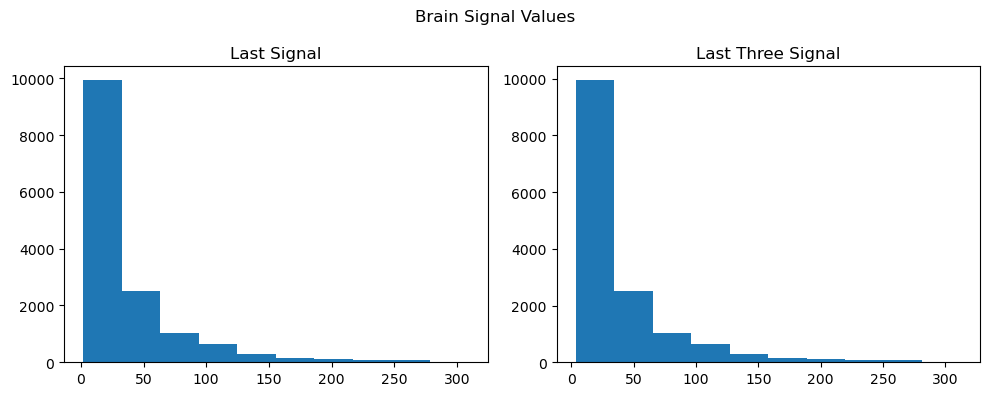

In [6]:
print(f"There are {len(np.nonzero(I_data[:,:,0])[0])} nonzero voxels")
x_vals = np.where(I_data[:,:,0]>0)[1]
y_vals = np.where(I_data[:,:,0]>0)[0]
print(f"The whole brain average final signal is {np.mean(I_data[y_vals, x_vals,-1]):.2f}")
print(f"The whole brain average final three signals is {np.mean(I_data[y_vals, x_vals,-3:]):.2f}")

rand_ind = [random.randint(0, len(y_vals)-1) for _ in range(1000)]
random_x = x_vals[rand_ind]
random_y = y_vals[rand_ind]

print(f"The random brain subsection average final signal is {np.mean(I_data[random_y, random_x,-1]):.2f}")
print(f"The random brain subsection average final three signals is {np.mean(I_data[random_y, random_x,-3:]):.2f}")

v1,v2,h1,h2 = noiseRegion
print(f"The periventricular brain subsection average final signal is {np.mean(I_data[v1:v2,h1:h2,-1]):.2f}")
print(f"The periventricular brain subsection average final three signals is {np.mean(I_data[v1:v2,h1:h2,-3:]):.2f}")

I_nonzero_last_val = I_data[y_vals,x_vals,-1]
I_nonzero_avg_last_val = np.mean(I_data[y_vals,x_vals,-3:],-1)
I_nonzero_first_val = I_data[y_vals,x_vals,0]
lower = np.percentile(I_nonzero_last_val, 25)
upper = np.percentile(I_nonzero_last_val, 75)
print(f"The inner quartile average final signal is {np.mean([i for i in I_nonzero_last_val if i >= lower if i<= upper]):.2f}")
lower = np.percentile(I_nonzero_avg_last_val, 25)
upper = np.percentile(I_nonzero_avg_last_val, 75)
print(f"The inner quartile average final three signal is {np.mean([i for i in I_nonzero_avg_last_val if i >= lower if i<= upper]):.2f}")

fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(10,4))
ax[0].hist(x = np.stack(I_data[y_vals, x_vals,-1]))
ax[0].set_title(f"Last Signal")
ax[1].hist(x = np.stack(np.mean(I_data[y_vals, x_vals,-3:],-1)))
ax[1].set_title(f"Last Three Signal")
fig.suptitle("Brain Signal Values")

In [7]:
noise_floor = np.mean(I_data[v1:v2,h1:h2,-3:])#np.mean([i for i in I_nonzero_avg_last_val if i >= lower if i<= upper])
sigma = noise_floor * (2/np.pi)**(1/2)
print("Determined from the Boxed Region")
print(f'sigma = {sigma}')
avg_init = np.mean(I_data[v1:v2,h1:h2,0])
print(f'SNR = {avg_init/sigma:0.2f}')

Determined from the Boxed Region
sigma = 20.4186049673904
SNR = 53.91


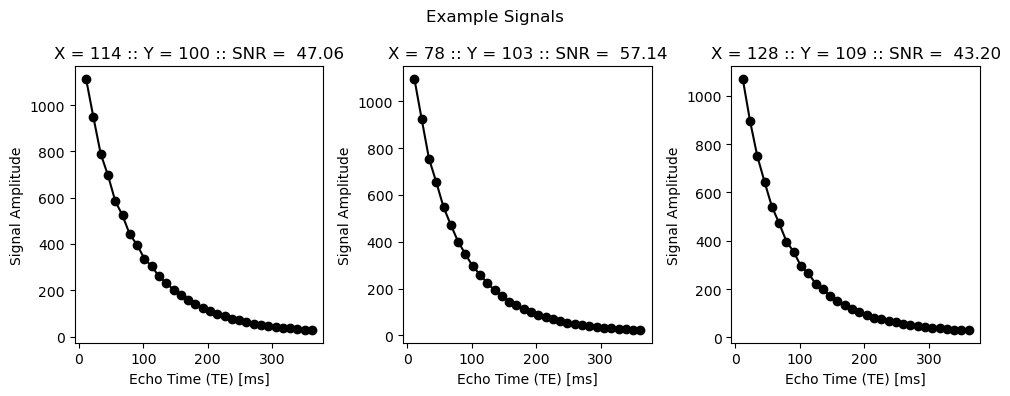

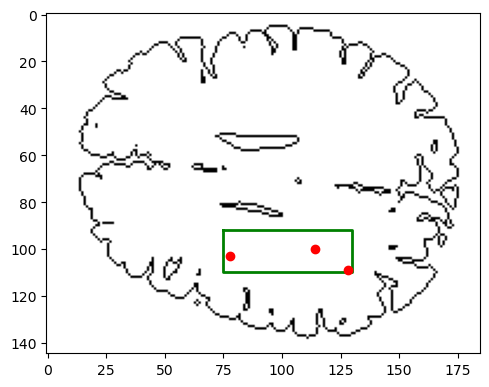

In [8]:
rand_x = [random.randint(h1, h2) for _ in range(3)]
rand_y = [random.randint(v1, v2) for _ in range(3)]

fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(10,4))
fig.suptitle('Example Signals')
for i in range(3):
    ax[i].plot(tdata, I_data[rand_y[i], rand_x[i], :], ls = '-', marker = 'o', color = 'k')
    ax[i].set_title(f"X = {rand_x[i]} :: Y = {rand_y[i]} :: SNR = {I_data[rand_y[i], rand_x[i], 0]/(np.mean(I_data[rand_y[i], rand_x[i], -3:]) * (2/np.pi)**(1/2)): .2f}")
    ax[i].set_ylabel('Signal Amplitude')
    ax[i].set_xlabel('Echo Time (TE) [ms]')

brain_outline = get_brain_outline(I_data)
fig, ax = plt.subplots(1,1,figsize=(5,5),tight_layout=True)
ax.imshow(1-brain_outline, cmap = 'gray')
ax.plot(hBox,vBox, linewidth = 2, color = 'g')
ax.plot(rand_x, rand_y, ls = '', color = 'r', marker = 'o')

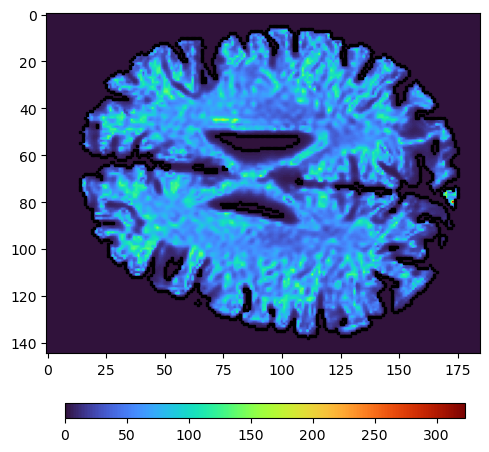

In [9]:
SNR_array = np.zeros((I_data.shape[0],I_data.shape[1]))


for i in range(len(x_vals)):
    SNR_array[y_vals[i],x_vals[i]] = I_data[y_vals[i], x_vals[i], 0]/(np.mean(I_data[y_vals[i], x_vals[i], -3:]) * (2/np.pi)**(1/2))

fig, ax = plt.subplots(1,1,figsize=(5,5),tight_layout=True)
imc1 = ax.imshow(SNR_array, cmap = 'turbo')
outline_indices = np.where(brain_outline == 1)
ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
cbar_ax = fig.add_axes([0.14, 0.03, 0.8, 0.03])
fig.colorbar(imc1, ax=ax, cax=cbar_ax, orientation = 'horizontal', fraction=0.046, pad=0.04)